---
title: "Comparing enformer predictions on edge vs center bins"
author: "Laura Vairus"
date: "2023-07-21"
---

In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

In [92]:
# Comparison functions

def get_diffmats(pre_avg, post_avg):
    pre = pre_avg
    post = post_avg
    
    # make diffmats
    diffmat = pre_avg - post_avg
    abs_diffmat = np.abs(diffmat)
    # rel_diffmat = abs_diffmat / (np.abs(pre_avg) + np.abs(post_avg) + 1**-16)
    # relmax_diffmat = get_relmax(abs_diffmat) 
    # relmed_diffmat = get_relmed(abs_diffmat) 
    # rel95_diffmat = get_rel99(abs_diffmat)

    # new diff mat
    pre_colwise_maxes = np.max(pre, axis=0)
    post_colwise_maxes = np.max(post, axis=0)

    tot_colwise_maxes = np.maximum(pre_colwise_maxes, post_colwise_maxes)

    relmax3_diffmat = diffmat / tot_colwise_maxes

    return relmax3_diffmat

    #return (abs_diffmat, rel_diffmat, relmax_diffmat, relmed_diffmat, rel95_diffmat)


def get_summary(arr):
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std_dev": np.std(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "total_sum": np.sum(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
        "iqr": np.percentile(arr, 75) - np.percentile(arr, 25)
    }
    return summary


def get_colwise_summary_df(arr):
    # Initialize empty dictionary
    col_summaries = {}
    # Compute summary statistics for each column and store in dictionary
    for col_index in range(arr.shape[1]):
        col_name = col_index
        col_data = arr[:, col_index]
        col_summary = get_summary(col_data)
        col_summaries[col_name] = col_summary
    # Convert dictionary to DataFrame
    col_summaries_df = pd.DataFrame(col_summaries).transpose()

    return col_summaries_df


def plot_tols_vs_outs(arr, mintol, maxtol, steps):
    # make x and y values
    x = np.linspace(maxtol, mintol, steps)
    y = []
    for tol in x:
        num_outs = len(get_outliers(arr, tol))
        out_perc = num_outs/arr.size
        print(f'tolerance: {round(tol, 2)}, num outs: {num_outs}, out percent: {out_perc}')
        y.append(out_perc)
    # plot x and y
    plt.scatter(x, y)
    plt.xlabel('tolerance')
    plt.ylabel('percentage of outliers')
    plt.show()

    return None


def get_outliers(arr, tol):
    outs = arr[arr > tol]

    return outs


def get_outlier_inds(arr, tol):
    # get list of ind tuples
    out_inds = np.where(arr > tol)
    out_inds_arr = np.array(list(zip(out_inds[0], out_inds[1])))
    # get list of row and col inds
    row_inds = out_inds[0]
    col_inds = out_inds[1]

    return [out_inds_arr, row_inds, col_inds]


def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

    return None


def plot_scatter(x, y, xlab="x", ylab="y", title="Scatter Plot"):
    plt.scatter(x, y)

    # Plot identity line
    plt.plot([min(x), max(x)], [min(x), max(x)], color='red')

    # Add labels and title
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

    # Show the plot
    plt.show()


def plot_array(arr):
    plt.plot(absdiff_12)
    
    # Adding a title and labels for clarity
    plt.title("Array Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Displaying the plot
    plt.show()

    return None


def plot_array_points(arr):
    plt.scatter(range(len(arr)), arr)

    # Adding a title and labels for clarity
    plt.title("Array Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Displaying the plot
    plt.show()

    return None


def make_outs_df(arr, tol):
    # get outliers and their inds
    outs = get_outliers(arr, tol)
    all_inds, row_inds, col_inds = get_outlier_inds(arr, tol)
    # make data
    data = {
        'name': df_targets['description'].iloc[col_inds],
        'bin': row_inds,
        'diff': outs,
        'system_slims': df_targets['system_slims'].iloc[col_inds],
        'cell_slims': df_targets['cell_slims'].iloc[col_inds],
        'organ_slims': df_targets['organ_slims'].iloc[col_inds],
        'developmental_slims': df_targets['developmental_slims'].iloc[col_inds]
    }
    # make df
    df = pd.DataFrame(data)
    # sort by ascending difference
    df_sorted = df.sort_values('diff')

    return df_sorted



In [2]:
with open('/grand/TFXcan/imlab/users/lvairus/shared_folder/enformer_pipeline/metadata/lvairus_3run_intervals.txt') as f:
    intervals = f.read().splitlines()
intervals = [i.strip('\"') for i in intervals]

In [111]:
f1 = h5py.File('/grand/TFXcan/imlab/users/lvairus/shared_folder/enformer_pipeline/3run_enformer_test2/predictions_folder/reference_enformer_minimal_some_regions/predictions_2023-07-21/3run_enformer_predictions/reference_enformer_minimal/haplotype0/chr14_50000000_50114688_predictions.h5')
e1 = f1['chr14_50000000_50114688'][()]
e1[:2]

array([[0.15065545, 0.19951393, 0.12778857, ..., 0.0090127 , 0.02072694,
        0.07220903],
       [0.13824955, 0.23091447, 0.1988252 , ..., 0.01056695, 0.02135748,
        0.08566103]], dtype=float32)

In [112]:
f2 = h5py.File('/grand/TFXcan/imlab/users/lvairus/shared_folder/enformer_pipeline/3run_enformer_test2/predictions_folder/reference_enformer_minimal_some_regions/predictions_2023-07-21/3run_enformer_predictions/reference_enformer_minimal/haplotype0/chr14_50057344_50172032_predictions.h5')
e2 = f2['chr14_50057344_50172032'][()]
e2[:2]

array([[0.09927819, 0.18940099, 0.1272915 , ..., 0.00978422, 0.03377192,
        0.02656003],
       [0.10379894, 0.18952276, 0.11001199, ..., 0.00488043, 0.02240965,
        0.0175203 ]], dtype=float32)

In [113]:
f3 = h5py.File('/grand/TFXcan/imlab/users/lvairus/shared_folder/enformer_pipeline/3run_enformer_test2/predictions_folder/reference_enformer_minimal_some_regions/predictions_2023-07-21/3run_enformer_predictions/reference_enformer_minimal/haplotype0/chr14_50114688_50229376_predictions.h5')
e3 = f3['chr14_50114688_50229376'][()]
e3[:2]

array([[0.05046384, 0.04647316, 0.03460554, ..., 0.01453539, 0.03015627,
        0.03420105],
       [0.08770172, 0.08309565, 0.05374731, ..., 0.01103948, 0.0331464 ,
        0.03604999]], dtype=float32)

In [57]:
bin1 = e1[-1]
bin21 = e2[447]
bin23 = e2[448]
bin3 = e3[0]

In [114]:
absdiff_12 = bin1-bin21
absdiff_32 = bin3-bin23

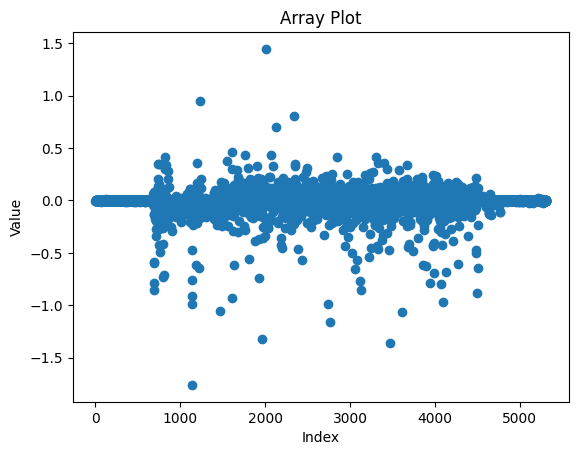

In [91]:
plot_array_points(absdiff_12)

In [64]:
relmax3diff_12 = (get_diffmats(bin1, bin21))

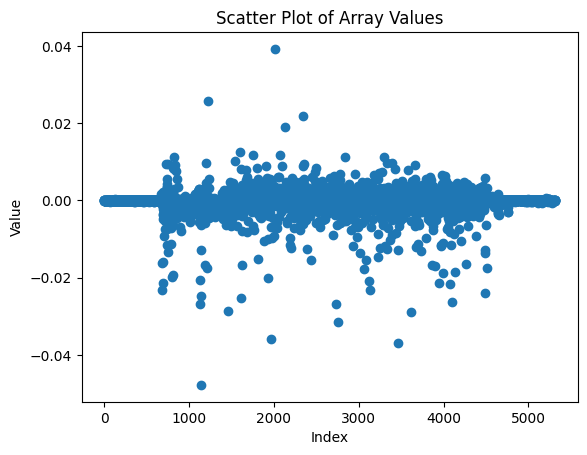

In [65]:
plt.scatter(range(len(relmax3diff_12)), relmax3diff_12)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Array Values')

# Show the plot
plt.show()

In [66]:
get_summary(absdiff_12)

{'mean': -0.010470782,
 'median': -0.0011529922,
 'std_dev': 0.10357857,
 'minimum': -1.76091,
 'maximum': 1.4468403,
 'total_sum': -55.631268,
 'q1': -0.0168379545211792,
 'q3': 0.006466269493103027,
 'iqr': 0.023304224014282227}

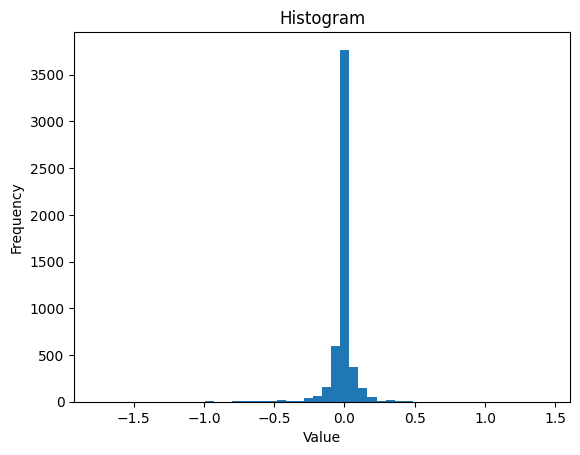

In [67]:
plot_hist(absdiff_12, 50)

In [68]:
get_summary(relmax3diff_12)

{'mean': -0.00028417687,
 'median': -3.1292187e-05,
 'std_dev': 0.0028111206,
 'minimum': -0.047791068,
 'maximum': 0.03926722,
 'total_sum': -1.5098317,
 'q1': -0.0004569817683659494,
 'q3': 0.0001754944387357682,
 'iqr': 0.0006324762071017176}

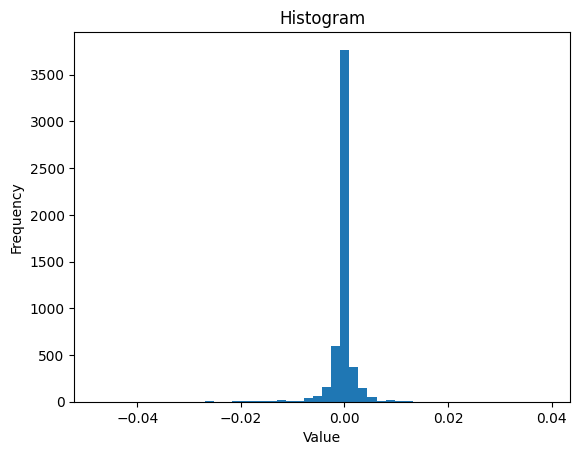

In [69]:
plot_hist(relmax3diff_12, 50)

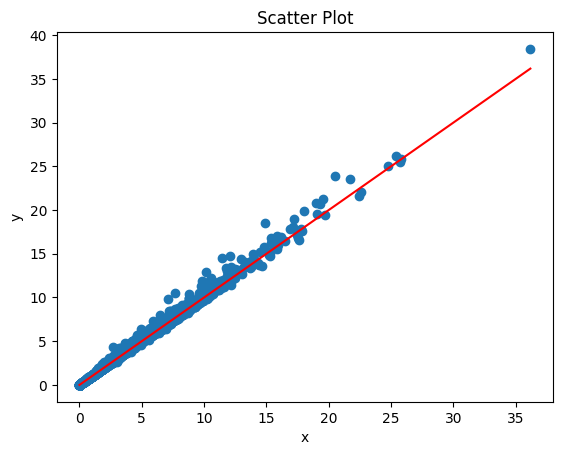

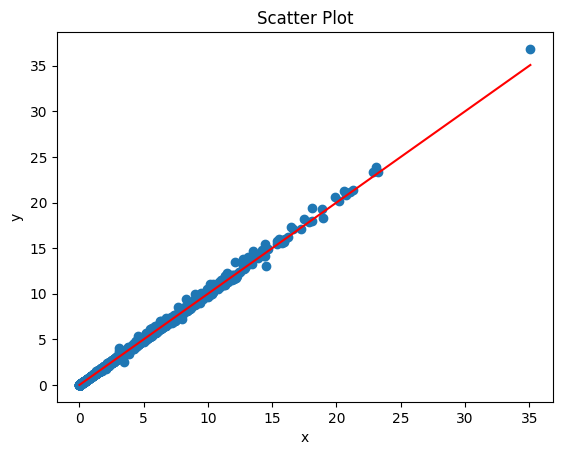

(None, None)

In [85]:
plot_scatter(bin3, bin23), plot_scatter(bin1, bin21)

In [70]:
sum(relmax3diff_12-absdiff_12)

54.121436111208936